# Plot SWOT fields and spectra AVISO Level 3

In this script we read in the SWOT data from a Pass between specified lats and plot the fields and spectra for the AVISO Level3 SWOT data. We also perform a comparison between Level 2 Version C, D and Level 3 Data

In [6]:
import jws_swot_tools as swot
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import SWOT L3 data and files for a pass between specified lats

In [21]:
# Read in the SWOT data for this pass
pass_num = 326
lat_max = 35 
lat_min = 28 

data_folder = f'/expanse/lustre/projects/cit197/jskinner1/SWOT/LEVEL_3/pass_{str(pass_num).zfill(3)}/'

# 1. Find overlapping cycles
files, shared_cycles, karin_files, nadir_files = swot.return_swot_l3_files(data_folder, pass_num)
print(f"Found {len(shared_cycles)} shared cycles.")

# 2. Get Indices of Karin and Nadir points in lat range
sample_index=0
indx, track_len, grid_width, nadir_pts, indx_nad = swot.get_l3_indices(karin_files[sample_index][0], lat_min, lat_max)

# 3. Init the classes as for the level 2 data 
dims_SWOT = [len(shared_cycles), track_len, nadir_pts]
karin3, nadir3 = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

# 3. Load the data into the KaRIn and Nadir classes
swot.load_l3_data(karin_files, indx, karin3, nadir3, lat_min, lat_max)

# 4. Process
swot.process_l3_karin(karin3)
swot.process_l3_nadir(nadir3)

# 5. Build the coordinate grids 
karin3.coordinates()
nadir3.coordinates()

# 6. Compute the Spectra 
karin3.compute_spectra()
nadir3.compute_spectra()

L3 Shared Cycles: [1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
Found 39 shared cycles.
KaRIn Rows: 395
Valid Nadir Points: 106
Skipping Cycle 25: 100.0% bad data.

Bad cycles: [25]

X grid range (km): 0.00 to 275.38 (span: 275.38 km)
Y grid range (km): 0.00 to 797.83 (span: 797.83 km)
Track Length: 797.83 km
Swath Width: 137.69 km
Karin spacing: dx = 1.99 km, dy = 2.01 km
Nadir spacing: dy = 7.50 km
Computing KaRIn spectra...


/home/jskinner1/SWOT_balanced_extraction/src/jws_swot_tools/import_and_process_level3.py:258: RuntimeWarning: Mean of empty slice
  ssha_mean_nadir = np.nanmean(nadir.ssh, axis=0)


Computing Nadir spectra...


### Plot the fields and spectra 

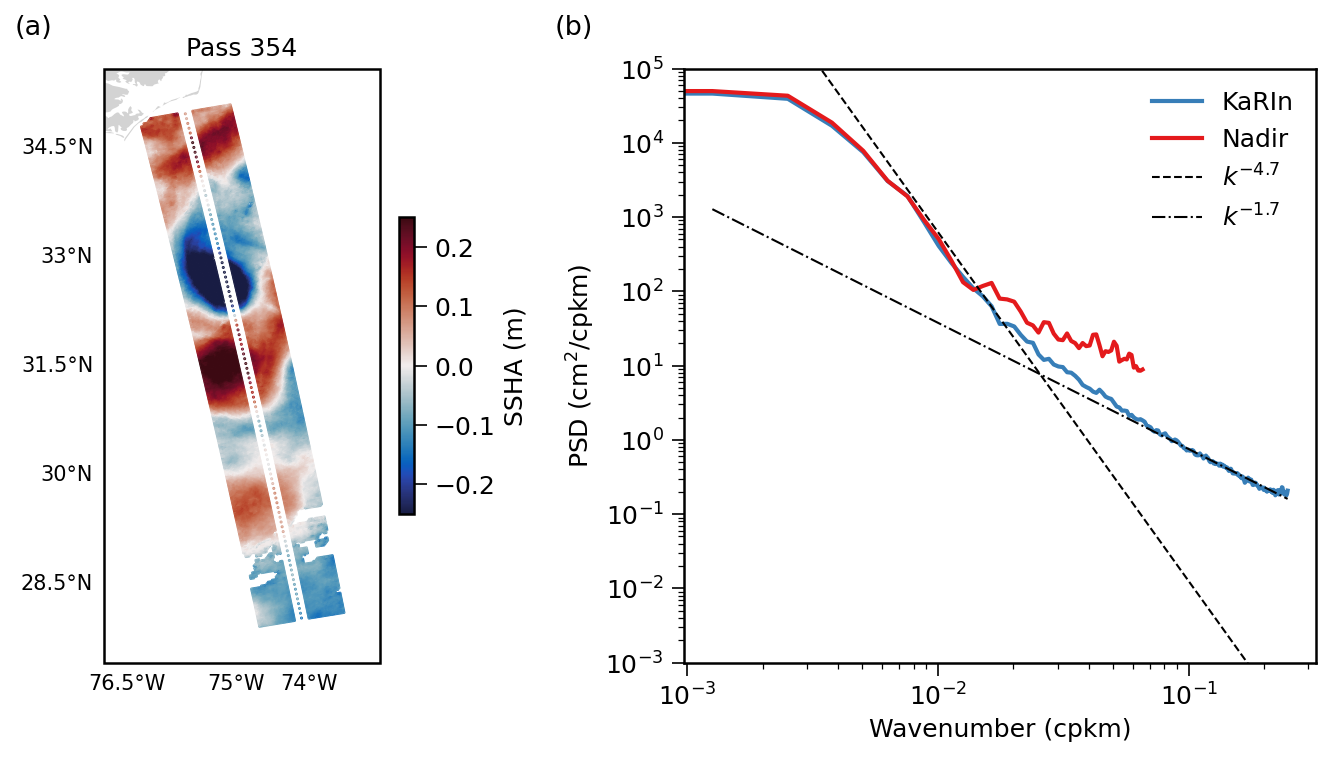

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy
import cartopy.crs as ccrs
import numpy as np
import cmocean

swot.set_plot_style()

index = 10
vmin, vmax = -0.25, 0.25
ylims = (1e-3, 1e5)
cmap = 'cmo.balance'

fig = plt.figure(figsize=(10, 5), dpi=150)
gs = GridSpec(1, 2, width_ratios=[1, 1.0], figure=fig)

# ───── SWOT Map ─────
# Define padding in degrees
pad = 0.5

lon_min_plot = np.nanmin(karin3.lon[index]) - pad
lon_max_plot = np.nanmax(karin3.lon[index]) + pad
lat_min_plot = np.nanmin(karin3.lat[index]) - pad
lat_max_plot = np.nanmax(karin3.lat[index]) + pad

ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_extent([lon_min_plot, lon_max_plot, lat_min_plot, lat_max_plot], crs=ccrs.PlateCarree())

sc0 = ax0.scatter(
    karin3.lon[index], karin3.lat[index],
    c=karin3.ssh[index], s=0.2, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax0.scatter(
    nadir3.lon[index], nadir3.lat[index],
    c=nadir3.ssh[index], s=0.2, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
#ax0.coastlines()
ax0.add_feature(cartopy.feature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax0.set_title(f'Pass {pass_num:03d}')
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.5, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax1 = fig.add_subplot(gs[0, 1])

ax1.loglog(karin3.wavenumbers_cpkm,  karin3.spec_ssh, label='KaRIn', linewidth=2.)
ax1.loglog(nadir3.wavenumbers_cpkm,  nadir3.spec_ssh, label='Nadir', linewidth=2.)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_ssh, label='SWOT KaRIn SSH', linewidth=2.0)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_tmean, label='SWOT Time-mean', linewidth=2.0)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_tide, label='SWOT HRET', linewidth=2.0)

# Reference slope lines (k^-5 and k^-2)
k_ref = karin3.wavenumbers_cpkm  # range of wavenumbers (cpkm)
C1 = 2.5e-7  # vertical placement for k^-5
C2 = 1.5e-2  # vertical placement for k^-2
ax1.loglog(k_ref, C1 * k_ref**-4.7, 'k--', linewidth=1, label=r'$k^{-4.7}$')
ax1.loglog(k_ref, C2 * k_ref**-1.7, 'k', linestyle='-.', linewidth=1, label=r'$k^{-1.7}$')

ax1.set_xlabel("Wavenumber (cpkm)")
ax1.set_ylabel("PSD (cm$^2$/cpkm)")
ax1.set_ylim(ylims)
ax1.legend()

# (a) for left panel
fig.text(0.13, 1, "(a)", fontsize=13, 
         va="top", ha="center")

# (b) for right panel
fig.text(0.49, 1, "(b)", fontsize=13, 
         va="top", ha="center")

plt.tight_layout()
fig.savefig("swot_map_spectrum.pdf", bbox_inches='tight')
plt.show()

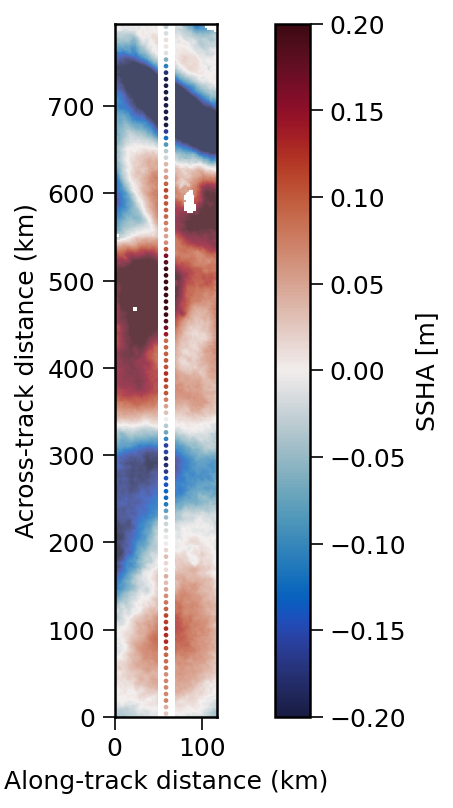

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean

# Pick an index to test
index = 0

# Mask invalid values
ssh_karin = np.ma.masked_invalid(karin3.ssha[index])
ssh_nadir = np.ma.masked_invalid(nadir3.ssha[index])

# Setup simple grid
nxt, nyt = karin3.ssha.shape[1], karin3.ssha.shape[2]
x_km = np.linspace(0, nyt * karin3.dx * 1e-3, nyt)
y_km = np.linspace(0, nxt * karin3.dy * 1e-3, nxt)
extent = [0, x_km.max(), 0, y_km.max()]

# Plot KaRIn SSH
plt.figure(figsize=(10, 6))
plt.imshow(
    ssh_karin, origin="lower", extent=extent, # this was a bug here 
    cmap="cmo.balance", vmin=-0.2, vmax=0.2, alpha=0.8, rasterized=True
)

# Overlay Nadir SSH points
plt.scatter(
    nadir3.x_grid * 1e-3, nadir3.y_grid * 1e-3,
    c=ssh_nadir, s=5, cmap="cmo.balance", vmin=-0.2, vmax=0.2,
    edgecolor="none", rasterized=True
)

plt.xlabel("Along-track distance (km)")
plt.ylabel("Across-track distance (km)")
plt.colorbar(label="SSHA [m]")
plt.show()

### Fit Spectrum Models to level 3


---- KaRIn spectrum parameters ----
Amp. balanced   :   4.6394e+04 ± 6.56e+02
lambda balanced :   2.8709e+02 ± 2.83e+00
slope balanced  :   4.4708e+00 ± 6.58e-02
Amp. noise      :   5.6504e+01 ± 4.89e+01
lambda noise    :   1.0000e+02 ± 5.00e+01
slope noise     :   1.8465e+00 ± 2.85e-02


---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 19.138974048724503 ± 1.46e+00



(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

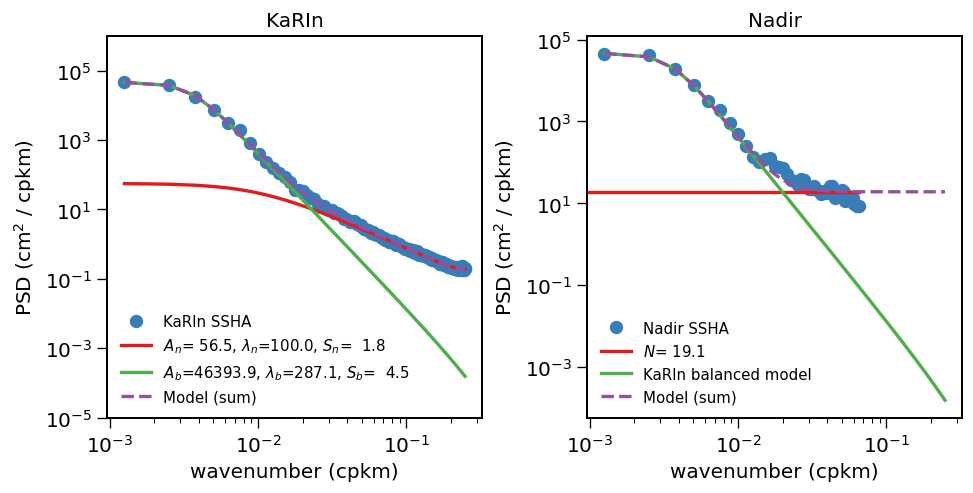

In [10]:
# KaRIn model fit
poptcwg_karin3, pcovcwg_karin3 = swot.fit_spectrum(karin3, karin3.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir3, covcwg_nadir3 = swot.fit_nadir_spectrum(nadir3, nadir3.spec_alongtrack_av, poptcwg_karin3)

# Plot the fits
swot.plot_spectral_fits(karin3, nadir3, poptcwg_karin3, poptcwg_nadir3, 'balanced_fits.pdf')

### Now import the Level 2 Data for Comparison

In [11]:
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/SCIENCE/' # version C data folder

# finds overlapping cycles between the karin and nadir datasets
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_num) 

sample_index = 2 # this is an index we use to import a preliminary file and get track indices 
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]

karin2C, nadir2C = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

# read and process the karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin2C, verbose=False)
swot.process_karin_data(karin2C)

# read and process the nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir2C)
swot.process_nadir_data(nadir2C)

# generate the coordinates
karin2C.coordinates()
nadir2C.coordinates()

# Compute spectra
karin2C.compute_spectra()
nadir2C.compute_spectra()

Shared Cycles: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


/home/jskinner1/SWOT_balanced_extraction/src/jws_swot_tools/import_and_process.py:289: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.022950384568182148
----------------------------------
Total Number of Good KaRIn strips : 50
Number of Quality Masked KaRIn strips : 49
Number of High Variance strips removed : 0
Number of Good Cycles: 25
Number of Cycles dropped (>20% masked): 2
----------------------------------

Number of good nadir cycles: 27
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 275.38 (span: 275.38 km)
Y grid range (km): 0.00 to 797.83 (span: 797.83 km)
Track Length: 797.83 km
Swath Width: 137.69 km
Karin spacing: dx = 1.99 km, dy = 2.01 km
Nadir spacing: dy = 7.09 km
Computing KaRIn spectra...
Computing Nadir spectra...


In [13]:
# Do same for version D so we can compare the spectra 
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/SCIENCE_VD/'

# import and process version D
sample_index = 2
_, _, shared_cycles, karin_files_vd, nadir_files_vd = swot.return_swot_files(data_folder, pass_num) 
indx, track_length = swot.get_karin_track_indices(karin_files_vd[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files_vd[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]
karin2D, nadir2D = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

swot.load_karin_data(karin_files_vd, lat_min, lat_max, karin2D, verbose=False)
swot.process_karin_data(karin2D)

swot.load_nadir_data(nadir_files_vd, lat_min, lat_max, nadir2D)
swot.process_nadir_data(nadir2D)

# generate the coordinates
karin2D.coordinates()
nadir2D.coordinates()

# Compute spectra
karin2D.compute_spectra()
nadir2D.compute_spectra()

Shared Cycles: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 39, 40]


/home/jskinner1/SWOT_balanced_extraction/src/jws_swot_tools/import_and_process.py:289: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.02136682929312942
----------------------------------
Total Number of Good KaRIn strips : 60
Number of Quality Masked KaRIn strips : 68
Number of High Variance strips removed : 0
Number of Good Cycles: 30
Number of Cycles dropped (>20% masked): 4
----------------------------------

Number of good nadir cycles: 34
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 275.38 (span: 275.38 km)
Y grid range (km): 0.00 to 797.83 (span: 797.83 km)
Track Length: 797.83 km
Swath Width: 137.69 km
Karin spacing: dx = 1.99 km, dy = 2.01 km
Nadir spacing: dy = 7.09 km
Computing KaRIn spectra...
Computing Nadir spectra...


In [14]:
# Finally, we want the level3 filtered as well for the comparison 
data_folder = f'/expanse/lustre/projects/cit197/jskinner1/SWOT/LEVEL_3/pass_{str(pass_num).zfill(3)}/'
files, shared_cycles, karin_files, nadir_files = swot.return_swot_l3_files(data_folder, pass_num)
print(f"Found {len(shared_cycles)} shared cycles.")
indx, track_len, grid_width, nadir_pts, indx_nad = swot.get_l3_indices(karin_files[0][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_len, nadir_pts]

karin3F, nadir3F = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)
swot.load_l3_data(karin_files, indx, karin3F, nadir3F, lat_min, lat_max, ssh_key='ssha_filtered')

# Process
swot.process_l3_karin(karin3F)
swot.process_l3_nadir(nadir3F)

# Build the coordinate grids 
karin3F.coordinates()
nadir3F.coordinates()

# Compute the Spectra 
karin3F.compute_spectra()
nadir3F.compute_spectra()

L3 Shared Cycles: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41]
Found 39 shared cycles.
KaRIn Rows: 395
Valid Nadir Points: 106
Skipping Cycle 9: 10.5% bad data.
Skipping Cycle 31: 60.0% bad data.
Skipping Cycle 36: 12.2% bad data.

Bad cycles: [9, 31, 36]



/home/jskinner1/SWOT_balanced_extraction/src/jws_swot_tools/import_and_process_level3.py:258: RuntimeWarning: Mean of empty slice
  ssha_mean_nadir = np.nanmean(nadir.ssh, axis=0)


X grid range (km): 0.00 to 275.38 (span: 275.38 km)
Y grid range (km): 0.00 to 797.83 (span: 797.83 km)
Track Length: 797.83 km
Swath Width: 137.69 km
Karin spacing: dx = 1.99 km, dy = 2.01 km
Nadir spacing: dy = 7.49 km
Computing KaRIn spectra...
Computing Nadir spectra...


### Compare the Level 2 and Level 3 fields and spectra

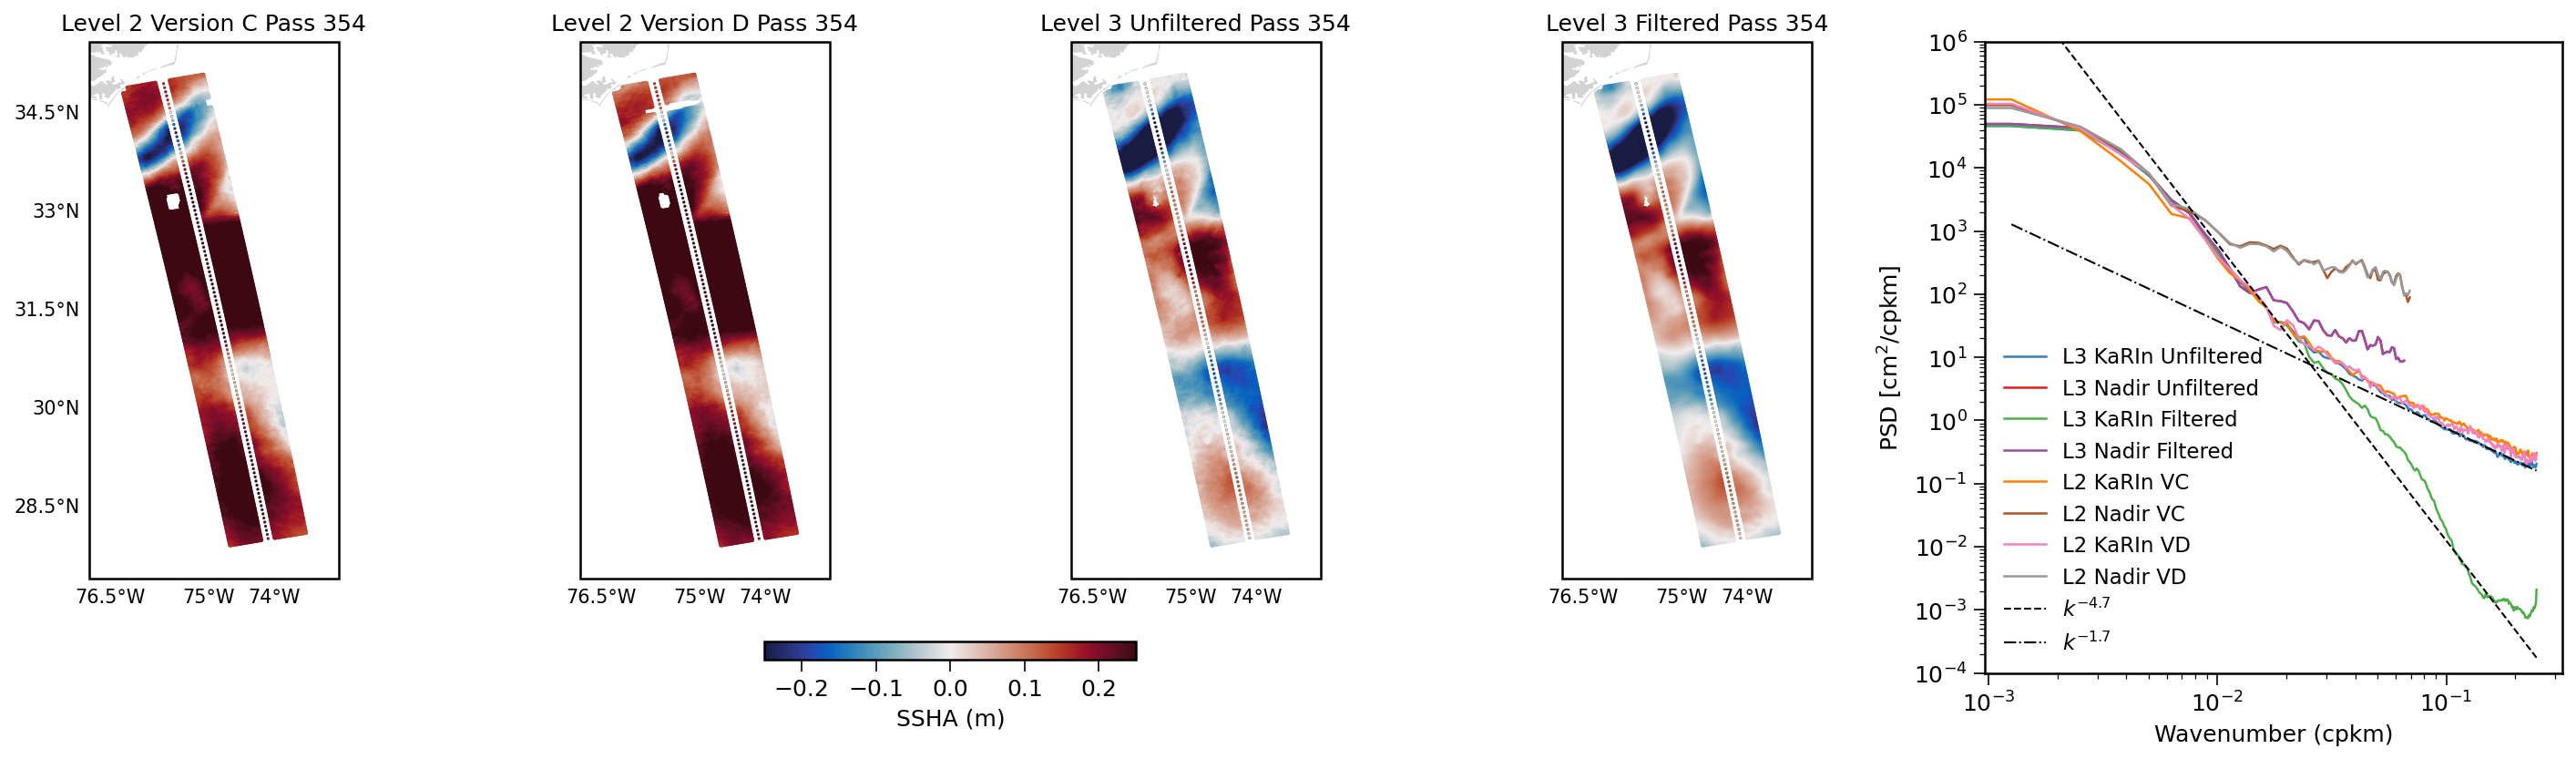

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

swot.set_plot_style()

index = 0
vmin, vmax = -0.25, 0.25
ylims = (1e-4, 1e6)
cmap = 'cmo.balance'

fig = plt.figure(figsize=(24, 6), dpi=150)
gs = GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1.5], figure=fig, wspace=0.25)

pad = 0.5

# --- Panel 1: Level 2 Version C ---
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_extent([lon_min_plot, lon_max_plot, lat_min_plot, lat_max_plot], crs=ccrs.PlateCarree())

sc0 = ax0.scatter(
    karin2C.lon[index], karin2C.lat[index],
    c=karin2C.ssha[index], s=1, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax0.scatter(
    nadir2C.lon[index], nadir2C.lat[index],
    c=nadir2C.ssha[index], s=2, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True, edgecolors='k', linewidths=0.1
)

ax0.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax0.set_title(f'Level 2 Version C Pass {pass_num:03d}')
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False


# --- Panel 2: Level 2 Version D ---
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax1.set_extent([lon_min_plot, lon_max_plot, lat_min_plot, lat_max_plot], crs=ccrs.PlateCarree())

ax1.scatter(
    karin2D.lon[index], karin2D.lat[index],
    c=karin2D.ssha[index], s=1, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax1.scatter(
    nadir2D.lon[index], nadir2D.lat[index],
    c=nadir2D.ssha[index], s=2, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True, edgecolors='k', linewidths=0.1
)

ax1.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax1.set_title(f'Level 2 Version D Pass {pass_num:03d}')
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl1.top_labels = gl1.right_labels = gl1.left_labels = False


# --- Panel 3: Level 3 Unfiltered ---
ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax2.set_extent([lon_min_plot, lon_max_plot, lat_min_plot, lat_max_plot], crs=ccrs.PlateCarree())

ax2.scatter(
    karin3.lon[index], karin3.lat[index],
    c=karin3.ssha[index], s=1, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax2.scatter(
    nadir3.lon[index], nadir3.lat[index],
    c=nadir3.ssha[index], s=2, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True, edgecolors='k', linewidths=0.1
)

ax2.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax2.set_title(f'Level 3 Unfiltered Pass {pass_num:03d}')
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl2.top_labels = gl2.right_labels = gl2.left_labels = False


# --- Panel 4: Level 3 Filtered ---
ax3 = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
ax3.set_extent([lon_min_plot, lon_max_plot, lat_min_plot, lat_max_plot], crs=ccrs.PlateCarree())

ax3.scatter(
    karin3F.lon[index], karin3F.lat[index],
    c=karin3F.ssha[index], s=1, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax3.scatter(
    nadir3F.lon[index], nadir3F.lat[index],
    c=nadir3F.ssha[index], s=2, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True, edgecolors='k', linewidths=0.1
)

ax3.add_feature(cfeature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax3.set_title(f'Level 3 Filtered Pass {pass_num:03d}')
gl3 = ax3.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl3.top_labels = gl3.right_labels = gl3.left_labels = False

# Shared colorbar
cbar = fig.colorbar(sc0, ax=[ax0, ax1, ax2, ax3], orientation='horizontal', fraction=0.05, pad=0.1, shrink=0.2)
cbar.set_label("SSHA (m)")


# --- Panel 5: Spectra ---
ax4 = fig.add_subplot(gs[0, 4])
ax4.loglog(karin3.wavenumbers_cpkm, karin3.spec_ssh, label='L3 KaRIn Unfiltered', linewidth=1.2)
ax4.loglog(nadir3.wavenumbers_cpkm, nadir3.spec_ssh, label='L3 Nadir Unfiltered', linewidth=1.2)

ax4.loglog(karin3F.wavenumbers_cpkm, karin3F.spec_ssh, label='L3 KaRIn Filtered', linewidth=1.2)
ax4.loglog(nadir3F.wavenumbers_cpkm, nadir3F.spec_ssh, label='L3 Nadir Filtered', linewidth=1.2)

ax4.loglog(karin2C.wavenumbers_cpkm, karin2C.spec_ssha, label='L2 KaRIn VC', linewidth=1.2, linestyle='-')
ax4.loglog(nadir2C.wavenumbers_cpkm, nadir2C.spec_ssha, label='L2 Nadir VC', linewidth=1.2, linestyle='-')

ax4.loglog(karin2D.wavenumbers_cpkm, karin2D.spec_ssha, label='L2 KaRIn VD', linewidth=1.2, linestyle='-')
ax4.loglog(nadir2D.wavenumbers_cpkm, nadir2D.spec_ssha, label='L2 Nadir VD', linewidth=1.2, linestyle='-')

k_ref = karin3.wavenumbers_cpkm
C1 = 2.5e-7
C2 = 1.5e-2
ax4.loglog(k_ref, C1 * k_ref**-4.7, 'k--', linewidth=1, label=r'$k^{-4.7}$')
ax4.loglog(k_ref, C2 * k_ref**-1.7, 'k', linestyle='-.', linewidth=1, label=r'$k^{-1.7}$')

ax4.set_xlabel("Wavenumber (cpkm)")
ax4.set_ylabel("PSD [cm$^2$/cpkm]")
ax4.set_ylim(ylims)
ax4.legend(fontsize=11)

fig.savefig("swot_map_spectrum_combined_vC_vD_L3_Unfilt_Filt.pdf", bbox_inches='tight')
plt.show()

### Compare spectrum models

In [ ]:
# KaRIn model fit
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)

# Plot the fits
swot.plot_spectral_fits(karin3, nadir3, poptcwg_karin3, poptcwg_nadir3, 'balanced_fits.pdf') # level 3
swot.plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir, 'balanced_fits.pdf') # level 2


Time 0:
KaRIn: 19294 points, lat 28.11 → 34.88
Nadir: 106 points, lat 28.01 → 34.95


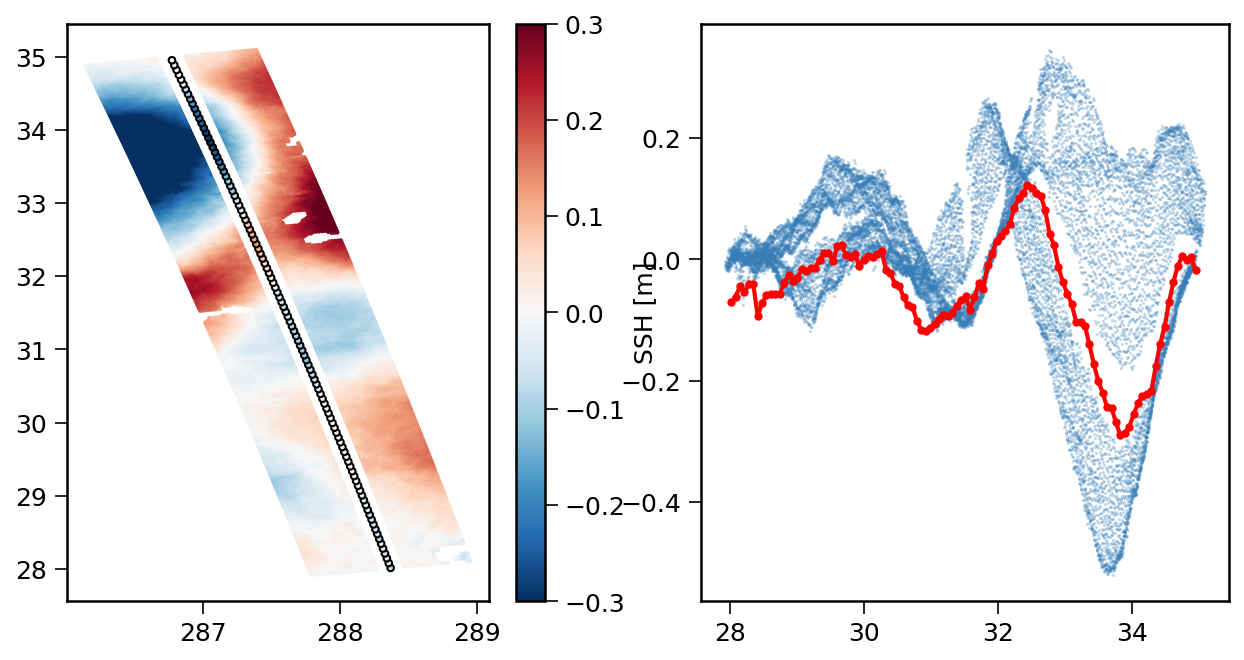

In [26]:
def check_karin_nadir_alignment(karin, nadir, t_idx=0, outdir="./"):
    # Get valid points
    mk = np.isfinite(karin.ssha[t_idx]).ravel(order="C")
    mn = np.isfinite(nadir.ssha[t_idx]).ravel()
    
    # Get data
    k_lat = karin.lat[t_idx].ravel(order="C")[mk]
    k_lon = karin.lon[t_idx].ravel(order="C")[mk]
    k_ssh = karin.ssha[t_idx].ravel(order="C")[mk]
    
    n_lat = nadir.lat[t_idx].ravel()[mn]
    n_lon = nadir.lon[t_idx].ravel()[mn]
    n_ssh = nadir.ssha[t_idx].ravel()[mn]
    
    # Print
    print(f"\nTime {t_idx}:")
    print(f"KaRIn: {len(k_lat)} points, lat {k_lat[0]:.2f} → {k_lat[-1]:.2f}")
    print(f"Nadir: {len(n_lat)} points, lat {n_lat[0]:.2f} → {n_lat[-1]:.2f}")
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(k_lon, k_lat, c=k_ssh, s=1, vmin=-0.3, vmax=0.3, cmap='RdBu_r')
    plt.scatter(n_lon, n_lat, c=n_ssh, s=10, vmin=-0.3, vmax=0.3, cmap='RdBu_r', edgecolor='k')
    plt.colorbar(label='SSH [m]')
    
    plt.subplot(122)
    plt.plot(k_lat, k_ssh, '.', markersize=1, alpha=0.3)
    plt.plot(n_lat, n_ssh, 'o-', markersize=3, color='red')
    plt.show()

check_karin_nadir_alignment(karin3, nadir3)
